<a href="https://colab.research.google.com/github/KGurito/Classifica_Imagens/blob/main/Copy_of_Verifica%C3%A7%C3%A3o_de_Ortografia_em_Imagens.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#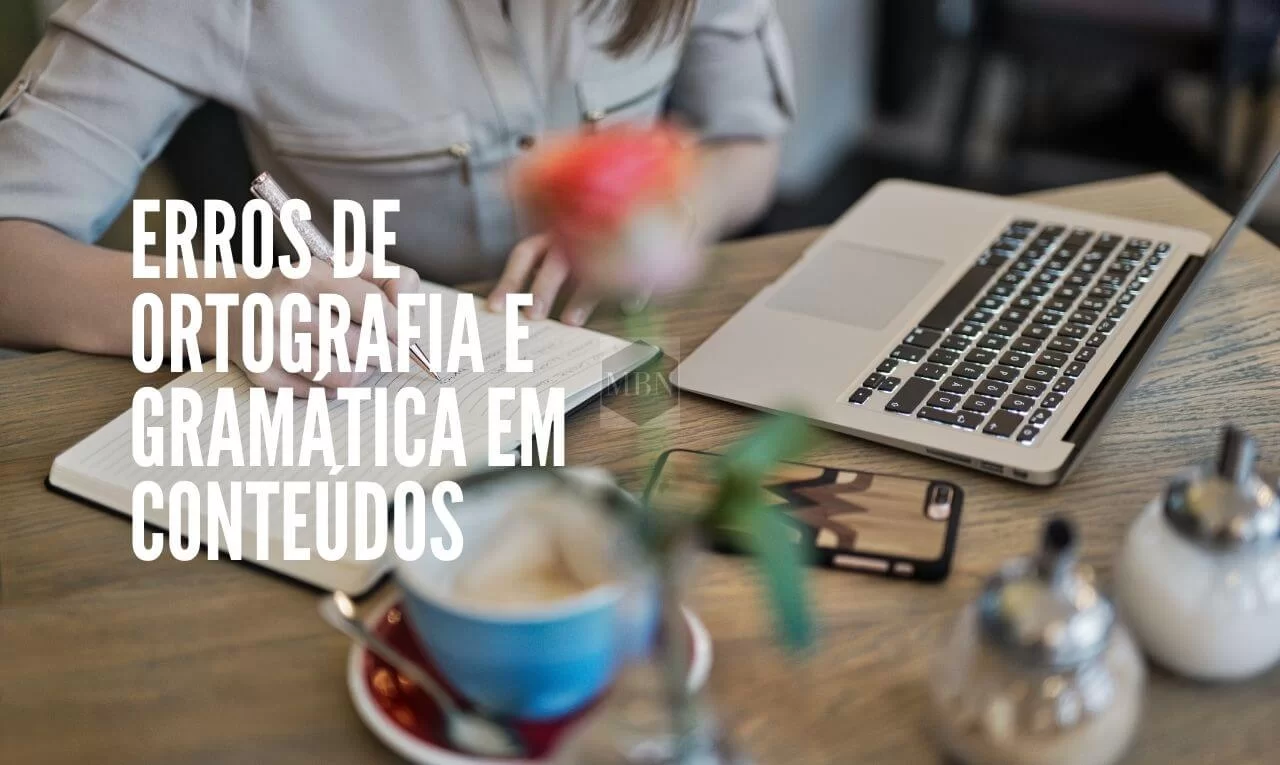

É muito comum que empresas de Marketing, resposáveis por postagens de conteúdo, não tenham tempo para verificar uma quantidade massiva de conteúdos e analisar sua ortografia e gramática.

Infelizmente, é comum vermos casos de postagens com gramática errada. Olhando a perspectiva das agências de Marketing, possuem uma grande responsabilidade nas mãos. Um erro no post pode acarretar em uma repercussão negativa para aquele perfil e podendo se tranformar em um processo contra a própria agência.

Zelar pela qualidade dos conteúdos sendo gerados para os clientes é um dos pilares que mantém esse mercado ativo e funcional.

Mas como podemos tranformar e facilitar a vida dos revisores de conteúdo? Acredito que o Gemini tenha uma respota para isso.

Usando inteligência Artifical, é possível transcrever o texto das imagens e clássificá-las se é preciso de revisão ou se estão prontas para postagem.

A seguir, segue uma sequência de códigos que une o poder das APIs na Plataforma do Google Cloud e sua Inteligência Artificial, O Gemini

# Apresentação da Solução Usando Gemini e Vertex AI

Instalação de Bibliotecas

In [ ]:
!pip install -q -U google-generativeai

In [ ]:
!pip install -q -U google-cloud-aiplatform

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 16.8 MB/s eta 0:00:00


Import das Bibliotecas no Projeto; Declaração da Google API Key

In [ ]:
import google.generativeai as genai
import vertexai
from google.oauth2 import service_account
from google.cloud import aiplatform
from google.cloud import storage
from vertexai.generative_models import GenerativeModel, Part

GOOGLE_API_KEY='API_KEY'
genai.configure(api_key=GOOGLE_API_KEY)

Criação de Credenciais Vertex AI;Especificar Projeto Google Cloud;Especificar Localização para o Processamento do Vertex AI

In [ ]:
# Autenticação com Google Cloud Plataform, assimilação do Projeto Cloud e localização da API Vertex AI
credentials = service_account.Credentials.from_service_account_file("/content/vertex-key.json")
project_id = "PROJECT_ID"
location="região" #exemplo: us-central1

Execução do Projeto para Classificação de Imagens com Erros Ortográficos


1.   Especificar os nomes do bucket e folder. Inicializar o Storage Cliente passando como parâmetro as credenciais JSON cadastradas anteriormente.
2.   armazenar o bucket à variável [bucket] e prefix a variável da pasta onde as imagens estão armazenadas
3.   Um Laço de repetição para listar os arquivos dentro da pasta e uma condição para trazer apenas arquivos brutos.
4. Armazena o path da imagem em [img] e executa os métodos generate_text e verifica_ortografia. Generate_text precisa dos parâmetros projeto ID, região Cloud e path da imagem. Em seguida, separo o nome da imagem da pasta, são separadas por '/'.
5. Separa as imagens que precisam de revisão das imagens liberadas



In [ ]:
#TASK 1
bucket_name = "images_for_revision"
folder_name = "images"  # e.g., "images/"

storage_client = storage.Client(credentials=credentials)



#TASK 2
bucket = storage_client.get_bucket(bucket_name)
    # Prefix to filter files within the specified folder
prefix = f"{folder_name}/"



#TASK 3
for blob in bucket.list_blobs(prefix=prefix):
  if blob.name.endswith("/") or blob.name.endswith(".ipynb"):
    continue
  else:



#TASK 4
    img = blob.name

    text = generate_text(project_id, location, img)
    ortografia = verifica_ortografia(text)

    nome = img.split("/")


#TASK 5
    if ortografia.upper() == 'NÃO':
      print(f"A imagem {nome[1]} pode seguir para o processo de postagens;LIBERADA \n")

    else:
      print(f"A imagem {nome[1]} precisa ser revisada;REVISÃO \n")

A imagem YM_Post.jpg precisa ser revisada;REVISÃO 

A imagem erro.jpg precisa ser revisada;REVISÃO 

A imagem frase.jpg pode seguir para o processo de postagens;LIBERADA 



Método para avaliar palavra por palavra do texto e verificar erros de ortografia e concordâncias verbais. Recebe como parâmetro o texto gerado pela Vertex AI no método posterior

In [ ]:
def verifica_ortografia(text: str) -> str:
  model = genai.GenerativeModel('gemini-1.0-pro')

  response = model.generate_content(f'Analise o seguinte texto palavra por palavra e retorne apenas um sim caso haja uma palavra com erro de conjugação verbal ou erro de ortografia no Português do Brasil, ou apenas um não caso esteja tudo correto: {text}')

  return(response.text)


Método para transcrever o texto da imagem analisada usando Vertex AI. Esse método recebe como parâmetro o projeto, região cloud e path do bucket onde a imagem está armazenada.

In [ ]:
def generate_text(project_id: str, location: str, img) -> str:
  vertexai.init(project=project_id, location=location, credentials=credentials)

  model = GenerativeModel(model_name="gemini-1.0-pro-vision")

  response = model.generate_content(
          [
              # Add an example image
              Part.from_uri(f"gs://images_for_revision/{img}", "image/jpeg"),
              # Add an example query
              "Transcreva o texto da imagem sem corrigir."
          ]
      )
  return(response.text)